In [1]:
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pyroomacoustics as pra
from scipy.io import loadmat


@dataclass
class PyData:
    fs: int
    grid: pra.doa.GridSphere
    impulse_responses: np.ndarray


@dataclass
class MatData:
    fs: int
    azimuth: np.ndarray
    colatitude: np.ndarray
    irs: np.ndarray

    @classmethod
    def from_file(cls, file_path: str | Path) -> "MatData":
        data = loadmat(file_path)
        return cls(
            fs=data["fs"].item(),
            azimuth=data["azimuth"],
            colatitude=data["colatitude"],
            irs=data["irs"],
        )

    def __str__(self):
        return (
            f"fs: {self.fs}, azimuth: {self.azimuth.shape}, colatitude: {self.colatitude.shape}, irs: {self.irs.shape}"
        )

    def to_pydata(self) -> PyData:
        return PyData(
            fs=self.fs,
            grid=self.get_grid(),
            impulse_responses=self.irs.transpose(),
        )

    def get_grid(self) -> pra.doa.GridSphere:
        """Turn the azimuth and colatitude into a grid spehere with cartesian coordinates"""
        x = np.sin(self.colatitude) * np.cos(self.azimuth)
        y = np.sin(self.colatitude) * np.sin(self.azimuth)
        z = np.cos(self.colatitude)
        grid = np.vstack((x, y, z))
        return pra.doa.GridSphere(n_points=grid.shape[1], cartesian_points=grid)

    def balloon_plot(self, freq: int = 1000) -> None:
        """Plot the directivity pattern in a 3D sphere"""
        from matplotlib import cm

        # Squeeze angles
        azimuth = self.azimuth.squeeze()
        colatitude = self.colatitude.squeeze()

        # Transpose for FFT (shape: directions x time)
        irs = self.irs.T

        # FFT
        fft_irs = np.fft.rfft(irs, axis=-1)
        n_fft = irs.shape[-1]
        freqs = np.fft.rfftfreq(n_fft, d=1 / self.fs)
        freq_idx = np.argmin(np.abs(freqs - freq))

        # Magnitude at 1 kHz
        magnitude = np.abs(fft_irs[:, freq_idx])
        magnitude /= np.max(magnitude)

        # Spherical to Cartesian
        x = np.sin(colatitude) * np.cos(azimuth) * magnitude
        y = np.sin(colatitude) * np.sin(azimuth) * magnitude
        z = np.cos(colatitude) * magnitude

        # Plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        # Smooth interpolation using trisurf with improved appearance
        surf = ax.plot_trisurf(x, y, z, cmap="viridis", linewidth=0, antialiased=True, edgecolor="none")

        # Match the original aesthetic
        ax.set_title(f"f = {freqs[freq_idx]:.0f} Hz", fontsize=16, weight="bold", pad=10)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.set_box_aspect([1, 1, 1])  # Equal aspect
        ax.view_init(elev=30, azim=45)  # Adjust camera angle

        # Remove grid and axes panes for a cleaner look
        ax.grid(False)
        for spine in ax.spines.values():
            spine.set_visible(False)
        plt.tight_layout()
        plt.savefig(f"directivity_{freq}_plot.png", dpi=300)
        plt.show()

    def balloon_plot_2d(self, freq: int = 1000) -> None:
        """2D polar plot of directivity pattern at 1 kHz (z = 0 plane)."""
        import matplotlib.pyplot as plt

        # Squeeze
        azimuth = self.azimuth.squeeze()
        colatitude = self.colatitude.squeeze()

        # Restrict to directions near the horizontal plane (colatitude ~ 90° or pi/2)
        horizontal_mask = np.isclose(colatitude, np.pi / 2, atol=0.1)
        azimuth_h = azimuth[horizontal_mask]
        irs = self.irs.T[horizontal_mask, :]  # shape: (n_horizontal_directions, 2048)

        # FFT
        fft_irs = np.fft.rfft(irs, axis=-1)
        freqs = np.fft.rfftfreq(irs.shape[-1], d=1 / self.fs)
        freq_idx = np.argmin(np.abs(freqs - freq))

        # Magnitude at 1 kHz
        magnitude = np.abs(fft_irs[:, freq_idx])
        magnitude /= np.max(magnitude)

        # Sort by azimuth for a smooth polar plot
        sorted_indices = np.argsort(azimuth_h)
        azimuth_sorted = azimuth_h[sorted_indices]
        magnitude_sorted = magnitude[sorted_indices]

        # Close the loop by appending first point at end
        azimuth_sorted = np.append(azimuth_sorted, azimuth_sorted[0])
        magnitude_sorted = np.append(magnitude_sorted, magnitude_sorted[0])

        # Plot
        fig = plt.figure()
        ax = fig.add_subplot(111, polar=True)
        ax.plot(azimuth_sorted, magnitude_sorted, color='b', linewidth=2)

        # Aesthetics
        ax.set_title(f"2D Directivity Pattern at {freqs[freq_idx]} Hz", fontsize=14, weight='bold', pad=20)
        ax.set_rticks([0.25, 0.5, 0.75, 1.0])  # optional: adjust ticks
        ax.set_rlabel_position(90)  # move radial labels
        ax.grid(True)

        plt.tight_layout()
        plt.show()


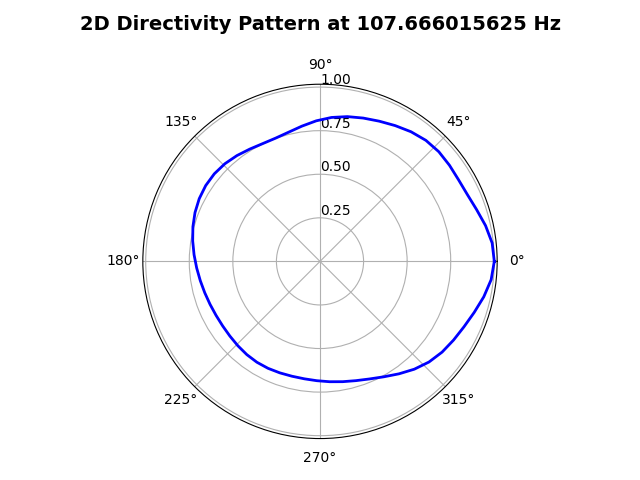

In [9]:
%matplotlib ipympl
measured_directivity_file_path = "/home/turib/thesis/3707708/AppliedAcousticsChalmers/sound-source-directivities-2020-03-12/AppliedAcousticsChalmers-sound-source-directivities-f48ec35/DirPat_singing_voice/irs_DirPat_a_long_sweep_N9_reg.mat"
mat_data = MatData.from_file(measured_directivity_file_path)
mat_data.balloon_plot_2d(100)

https://github.com/AppliedAcousticsChalmers/sound-source-directivities/blob/master/voice/singing_voice_DirPat/singing_voice_a_long_sweep_reg.png